## Article 1

The first interesting article I found was:

[Jerrett, Michael, Richard T. Burnett, Renjun Ma, C. Arden Pope III, Daniel Krewski, K. Bruce Newbold, George Thurston et al. "Spatial analysis of air pollution and mortality in Los Angeles." Epidemiology (2005): 727-736.](https://www.jstor.org/stable/20486136?casa_token=zwJo2wLvcnMAAAAA%3Aruo-xejz_HU9HgnZF2ADcoi8tjCE74o_GHnfksM_bqk-RvLCWtVq8LEPt7xFJZS7ruWKELoFQiZ-kPv4z7eIxV_sJjIb5A-2BIGnFt_M_cS3yDVElUOj)

This article introduced me to the idea that **PM$_{2.5}$** and **O$_3$** levels might be a good way to measure air quality. Of course, we might also simply want to use the Air Quality Index (AQI) if that is available to us in through the EPA AQS API. Can we see if we can extract data on PM$_{2.5}$ and O$_3$ levels in Los Angeles through the EPA AQS API?

### Issue with Air Quality Data

In our meeting on 08 May 2023, we noticed that there might not be enough weather stations provided in the AQS API. Apple Maps seems to provide much more air quality information than what we have see so far on the AQS API. Apple Maps says on their website that they get their air quality data from **BreezoMeter** and **QWeather**. It looks like [AirNow API](https://docs.airnowapi.org/webservices) gives us data on fine particulate matter, ozone, and AQI by ZIP code!

Update on 11 May 2023: It is looking increasingly likely that there are no air quality resources out there that will let us query in large volumes of historical time series data. We might have to change our initial question to account for the data availability.

## Article 2

Another interesting piece I found was:

Lisa Schweitzer & Jiangping Zhou (2010) Neighborhood Air Quality, Respiratory Health, and Vulnerable Populations in Compact and Sprawled Regions, Journal of the American Planning Association, 76:3, 363-371, DOI: [10.1080/01944363.2010.486623](https://doi.org/10.1080/01944363.2010.486623)

I quote the main interesting finding from the abstract: "Exposures to both ozone and fine particulates are also higher in neighborhoods with high proportions of African Americans, Asian ethnic minorities, and poor households."

In essence, it may be a good idea to explore how air quality varies with **racial/ethnic composition** and **income** throughout Los Angeles. I should note here that the article aggregates findings from 80 different U.S. cities (i.e. this study does not focus on Los Angeles). However, it still gives us a lead as to which demographic characteristics of LA residents might vary with air quality.

Can we see what racial/ethnic and income information we can get from the U.S. Census? I will note that Louise provided a great PDF guide on how to access data from the Census API, so we should definitely look into that while we try to query data from there.

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Let's take a closer look at the Census query url. The Census website gives the example url

`pd.read_json("https://api.census.gov/data/2019/pep/charagegroups?get=NAME,POP&HISP=2&for=state:*")`

Focus on the bold sections of the url.

### Year

api.census.gov/data/**2019**/pep/charagegroups?get=NAME,POP&HISP=2&for=state:*

According to an example in the manual, we can replace this with `timeseries` to get data across multiple years. This only works with time series datasets, so we will have to replace the data set name as shown below.

### Data set

api.census.gov/data/2019/**pep**/charagegroups?get=NAME,POP&HISP=2&for=state:*

To get data from the American Community Survey (ACS), we can replace this section. In some examples in the manual, they replaced this with /acs/acs1.

[Here](https://api.census.gov/data.html) is a list of different Census data sets.

### Querying Data

Let's see if we can import data on racial/ethnic composition and income in LA from the U.S. Census API.

In [93]:
# Specify your API key.
# This is not actually necessary to query the necessary data.
api_key = "YOUR_API_KEY_HERE"

# Specify the variables of interest
variables = "B01003_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B02001_007E,B02001_008E,B03001_003E,B19013_001E"

# Specify the geography of interest (Los Angeles County, California)
state = "06"
county = "037"
place = "*" # Wildcard to include all places within the county
tract = "*" # Wildcard to include all tracts within the place

# Build the API URL with API key
#url = f"https://api.census.gov/data/2019/acs/acs5/?get={variables}&for=tract:{tract}&in=place:{place}&in=county:{county}&in=state:{state}&key={api_key}"

#Without API key:
#url = f"https://api.census.gov/data/2019/acs/acs5?get={variables}&for=tract:{tract}&in=place:{place}&in=county:{county}&in=state:{state}"

#data = pd.read_json(url)

The above code does not seem to work yet. If you copy and paste the url to a browser, it says `error: unknown/unsupported geography heirarchy`. We can probably change tract, place, county, etc. to avert this issue. The following url seems to work, though. It feels like we are really close to querying the data we want.

Note about the variable codes: we have the total population (`B01003_001E`), the population that identifies as White alone (`B02001_002E`), the population that identifies as Black or African American alone (`B02001_003E`), the population that identifies as American Indian and Alaskan Native alone (`B02001_004E`), the population that identifies as Asian alone (`B02001_005E`), the population that identifies as Native Hawaiian and other Pacific islander alone (`B02001_006E`), the population that identifies as some other race alone (`B02001_007E`), the population that identifies as two or more races (`B02001_008E`), the population that identifies as Hispanic or Latino (`B03001_003E`), and the median household income (`B19013_001E`).

Find more information on variables in ACS5 [here](https://api.census.gov/data/2019/acs/acs5/variables.html).

Note also that we use the acs5 data set here. Information on when to use the ACS 1-year, 3-year, and 5-year estimates can be found [here](https://www.census.gov/programs-surveys/acs/guidance/estimates.html). The website says that 5-year estimates are the most accurate, yet the least current. In addition, the sample size is reduced when you move from 5-year to 3-year and 3-year to 1-year data. Because we are not necessarily interested in how current the data is, we choose the most accurate data (5-year).

### Retrieval of ZIP Codes

I obtained a list of LA ZIP codes from [this website](https://geohub.lacity.org/datasets/71b2fed2c1f24fc8850f5b7f8d2a320a/explore?location=34.060494%2C-118.413353%2C12.98). This list corresponds to the CSV titled `la_county_zip_codes.csv`. 

I compare the ZIP codes from this website with the ZIP codes scraped from the Internet.

In [4]:
zip_codes_df = pd.read_csv('la_county_zip_codes.csv')
zip_codes_df

,OBJECTID,ZIPCODE,ZIP,TOOLTIP,NLA_URL
0,1,90001,90001,Zip Code: 90001,navigatela/reports/zipcode_county_report.cfm?p...
1,2,90002,90002,Zip Code: 90002,navigatela/reports/zipcode_county_report.cfm?p...
2,3,90003,90003,Zip Code: 90003,navigatela/reports/zipcode_county_report.cfm?p...
3,4,90004,90004,Zip Code: 90004,navigatela/reports/zipcode_county_report.cfm?p...
4,5,90005,90005,Zip Code: 90005,navigatela/reports/zipcode_county_report.cfm?p...
...,...,...,...,...,...
306,307,93552,93552,Zip Code: 93552,navigatela/reports/zipcode_county_report.cfm?p...
307,308,93553,93553,Zip Code: 93553,navigatela/reports/zipcode_county_report.cfm?p...
308,309,93563,93563,Zip Code: 93563,navigatela/reports/zipcode_county_report.cfm?p...
309,310,93591,93591,Zip Code: 93591,navigatela/reports/zipcode_county_report.cfm?p...


In [5]:
#it looks like the `ZIPCODE` and `ZIP` columns are the same. We check if that is true.

for i in range(311):
    if zip_codes_df["ZIPCODE"][i] != zip_codes_df["ZIP"][i]:
        print("error")
        
#it appears that the assumption is true.

In [6]:
#we check the data type of the entries in `zip`
zip_codes = zip_codes_df["ZIP"]
type(zip_codes[1])

numpy.int64

In [7]:
zip_codes = zip_codes.tolist()

#querying in the data from the U.S. Census again
data = pd.read_json("https://api.census.gov/data/2019/acs/acs5?get=B01003_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B02001_007E,B02001_008E,B03001_003E,B19013_001E&for=zip%20code%20tabulation%20area:*&in=state:06")

#replacing the column titles with the first row
data.columns = data.iloc[0]

#cleaning up the data
data = data.drop([0])
data["zip code tabulation area"] = data["zip code tabulation area"].astype(int)

data = data[data["zip code tabulation area"].isin(zip_codes)]
data

,B01003_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B02001_007E,B02001_008E,B03001_003E,B19013_001E,state,zip code tabulation area
7,14285,2866,577,73,1445,0,8877,447,11428,50149,06,90716
8,21508,12081,1325,170,3531,82,2794,1525,7276,71388,06,90717
9,60659,34014,4289,383,3299,117,14179,4378,34549,53456,06,90731
10,56880,30323,1672,1630,1828,262,18949,2216,50588,50875,06,90744
11,27075,4032,17270,188,2212,341,1799,1233,4848,89364,06,90746
...,...,...,...,...,...,...,...,...,...,...,...,...
1365,0,0,0,0,0,0,0,0,0,-666666666,06,90095
1366,0,0,0,0,0,0,0,0,0,-666666666,06,90506
1367,0,0,0,0,0,0,0,0,0,-666666666,06,90747
1368,11545,5696,1305,8,2910,21,1060,545,3671,75426,06,90755


In [8]:
#cleaning up the column names
data.columns = ["pop_total", "pop_white", "pop_black","pop_aian", "pop_asian", "pop_nhpi", "pop_other_race", "pop_two_plus_races","pop_hispanic_latino", "income_median_household", "state_code", "zip_code"]

data

,pop_total,pop_white,pop_black,pop_aian,pop_asian,pop_nhpi,pop_other_race,pop_two_plus_races,pop_hispanic_latino,income_median_household,state_code,zip_code
7,14285,2866,577,73,1445,0,8877,447,11428,50149,06,90716
8,21508,12081,1325,170,3531,82,2794,1525,7276,71388,06,90717
9,60659,34014,4289,383,3299,117,14179,4378,34549,53456,06,90731
10,56880,30323,1672,1630,1828,262,18949,2216,50588,50875,06,90744
11,27075,4032,17270,188,2212,341,1799,1233,4848,89364,06,90746
...,...,...,...,...,...,...,...,...,...,...,...,...
1365,0,0,0,0,0,0,0,0,0,-666666666,06,90095
1366,0,0,0,0,0,0,0,0,0,-666666666,06,90506
1367,0,0,0,0,0,0,0,0,0,-666666666,06,90747
1368,11545,5696,1305,8,2910,21,1060,545,3671,75426,06,90755


Now that we have the data for 2019, let's see if we can construct a box plot of one of the variables to see how it varies.

<Axes: >

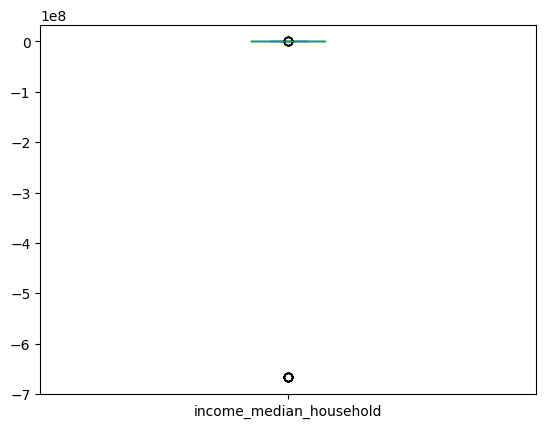

In [13]:
data = data.astype({'income_median_household':'int'})

data['income_median_household'].plot(kind = "box")

It looks like there is some problem with the plotting. Let's see what could be wrong.

In [14]:
#performing exploratory analysis to determine what could be wrong.
data['income_median_household'].mean()

#it is clear that there are negative numbers in a column that should not contain any negative values.
    #Let's identify which columns have this feature.

-26591921.946666665

In [15]:
data[data['income_median_household'] < 0]

#it appears that there are quite a few columns where the median household income is negative.
    #for now, let's convert these negative values to NA.
    
data['income_median_household'].loc[data['income_median_household'] < 0] = pd.NA
#this appears to return a small error, but based on the next cell, it seems to work fine in practice.
    #what can change in the future to avoid this issue?

/var/folders/v9/2tqxl6c10dx5ddj96lxyrw6w0000gn/T/ipykernel_31550/1956071327.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['income_median_household'].loc[data['income_median_household'] < 0] = pd.NA


<Axes: >

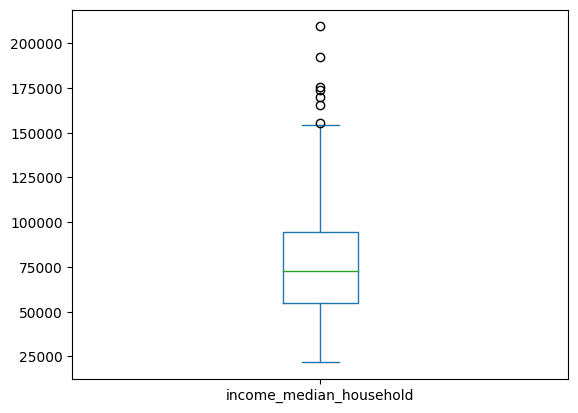

In [105]:
#we rerun the box plot code.
data['income_median_household'].plot(kind='box')

In [106]:
#Looks great! There appears to be significant variation in income throughout the county.
#Let's look at the outliers some more.

data[data['income_median_household'] > 150000]

,pop_total,pop_white,pop_black,pop_aian,pop_asian,pop_nhpi,pop_other_race,pop_two_plus_races,pop_hispanic_latino,income_median_household,state_code,zip_code
91,11882,10113,101,0,1067,0,88,513,1186,154583.0,06,90402
128,25061,17259,259,8,6088,0,323,1124,2155,169919.0,06,90274
168,15292,13405,237,29,836,20,300,465,1306,174085.0,06,91436
509,4872,2236,61,0,2133,0,114,328,1010,151071.0,06,92823
625,21629,18972,86,20,1251,6,79,1215,1009,192500.0,06,90272
641,8382,6905,229,0,713,0,69,466,314,209531.0,06,90077
653,17954,15887,271,65,691,27,172,841,1743,152378.0,06,90265
654,35500,27766,191,79,4787,34,667,1976,2838,153023.0,06,90266
1072,20301,12249,154,0,6317,0,374,1207,2029,175652.0,06,91011
1207,13375,4338,246,0,7979,27,379,406,839,165765.0,06,91108


In [108]:
#we can also look at the ZIP code encompassing most of Westwood.
data[data['zip_code'] == 90007]

,pop_total,pop_white,pop_black,pop_aian,pop_asian,pop_nhpi,pop_other_race,pop_two_plus_races,pop_hispanic_latino,income_median_household,state_code,zip_code
632,42433,15623,4548,289,8277,66,12071,1559,21672,27406.0,06,90007


## Remaining Questions

- How are we going to merge locality data across the U.S. Census and AQS API? By ZIP code, for instance? This will be a very important consideration and may cause us to change our research question depending on data availability.
- How are we going to obtain time series data for Census data? One easy, though possibly inefficient, way is to run a `for` loop where we change the year in the Census query url.
- Is ACS5 the best dataset to use? My understanding is that ACS5 gives 5-year estimates of the variables included. We will need to decide if this is what we really want.
- If we use the ACS, no matter the year range of the estimates, the historical data ends in the early 2000s. Will we want to dig back for more data from other sources?
- There appears to be significant issues with obtaining air quality data from small localities. Will we have to change our initial question? For example, should we explore the idea of looking a county-level air quality data across the United States?

## Wrapping Current Work in Function

In [31]:
def query_acs5(year):
    
    '''
    Query 5-year ACS racial/ethnic and median income data for all zip codes in LA county between 2011 and 2019.
    
    Args:
        year: year for which we want to gether data.
        
    Returns:
        a pandas dataframe with the desired data
    '''
    
    zip_codes_df = pd.read_csv('la_county_zip_codes.csv')
    zip_codes_df
    
    zip_codes = zip_codes_df["ZIP"]
    
    zip_codes = zip_codes.tolist()

    #querying in the data from the U.S. Census again
    data = pd.read_json(f"https://api.census.gov/data/{year}/acs/acs5?get=B01003_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B02001_007E,B02001_008E,B03001_003E,B19013_001E&for=zip%20code%20tabulation%20area:*&in=state:06")

    #replacing the column titles with the first row
    data.columns = data.iloc[0]

    #cleaning up the data
    data = data.drop([0])
    data["zip code tabulation area"] = data["zip code tabulation area"].astype(int)

    data = data[data["zip code tabulation area"].isin(zip_codes)]
    data.columns = ["pop_total", "pop_white", "pop_black","pop_aian", "pop_asian", "pop_nhpi", "pop_other_race", "pop_two_plus_races","pop_hispanic_latino", "income_median_household", "state_code", "zip_code"]
    
    return data

In [32]:
#testing query
query_acs5(2015)

,pop_total,pop_white,pop_black,pop_aian,pop_asian,pop_nhpi,pop_other_race,pop_two_plus_races,pop_hispanic_latino,income_median_household,state_code,zip_code
1,77877,28944,1308,744,13454,227,31517,1683,59336,51706,06,91706
2,84812,46375,4180,698,9404,177,17552,6426,46248,72620,06,91710
3,36651,25083,1569,234,5716,66,2389,1594,8206,89161,06,91711
10,37163,20485,9649,134,1950,13,2987,1945,10913,86310,06,91001
171,1145,868,18,0,0,0,147,112,145,56205,06,93544
...,...,...,...,...,...,...,...,...,...,...,...,...
1739,43805,11451,1111,131,26716,96,2823,1477,8973,93301,06,91789
1740,33247,14772,1530,178,8147,64,7117,1439,17222,71528,06,91791
1742,19969,16388,379,41,1814,0,710,637,5126,71411,06,91040
1743,47543,36770,814,307,3494,28,5072,1058,33541,51154,06,91352


## For the Air Quality measures
- We've tested multiple APIs, and we think **US official EPA AQS** and **Airnow** database fit better with our research questions.
- Still, Air quality data is NOT evenly distributed in either time or geographic locations; We'll need to figure out a way to integrate census and air quality measures.

- Data query is achieved through pull request. For clearity, I'm not showing the entire process of the obtaining the data. I'll use one *time slice* to demonstrate the complexity of air quality measures.

In [1]:
import pandas as pd

df = pd.read_csv("Air_quality_query/CA_2010_PM2.5.csv") 

## this is one year of data on only one pollutant (PM2.5) for state of California

df.shape ## (240999, 29) 



C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_1272\438880310.py:3: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Air_quality_query/CA_2010_PM2.5.csv")


(240999, 29)

In [2]:
## display what columns we have
df.columns

Index(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter', 'date_local',
       'time_local', 'date_gmt', 'time_gmt', 'sample_measurement',
       'units_of_measure', 'units_of_measure_code', 'sample_duration',
       'sample_duration_code', 'sample_frequency', 'detection_limit',
       'uncertainty', 'qualifier', 'method_type', 'method', 'method_code',
       'state', 'county', 'date_of_last_change', 'cbsa_code'],
      dtype='object')

To show case the visualization, we can display all the avaliable measures at a given time ~~

In [3]:
sub_df = df.loc[df['date_gmt'] == '2010-02-07', ['time_gmt', 'latitude', 'longitude', 'sample_measurement', 'date_local', 'site_number']]
sub_df = sub_df.loc[df['time_gmt'] == '08:00']

import plotly.express as px
fig = px.scatter_mapbox(sub_df, lat="latitude", lon="longitude", hover_data=["sample_measurement", "site_number"],
                        color_discrete_sequence=["fuchsia"], zoom=10, height=300)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
